In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.chdir("..")

from IPython.display import display

import sklearn.model_selection
import sklearn.metrics
import sklearn.datasets
from sklearn.ensemble import GradientBoostingClassifier

from Final_Data_Prep import remove_final_dummy, get_train_test, downsample

%matplotlib inline

import sys
sys.path.append("../")

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# read in fresh copy of df
df = pd.read_pickle('total_df.pckl.gz', compression = 'gzip')

In [5]:
'''
Data Prep (consistent with ADS as seen in Final_Gradient_Boosting_Model.ipynb)

Performing prep on total_df (here called df), not decoded_df as above in LIME
'''

#put earliest 85% of cases into training df, latest 15% of cases into test df
training, test = get_train_test(df, train_size=0.85, test_size=0.15)

# passing 50 to downsample function means training set will have 50% positive cases
training = downsample(training, 50)

X_train = training.drop('MHI', axis=1)
y_train = training['MHI']

X_test = test.drop('MHI', axis=1)
y_test = test['MHI']

In [6]:
clf_total = GradientBoostingClassifier(random_state=42, max_depth = 3, 
                                       min_samples_leaf = 10, learning_rate=.01, 
                                       n_estimators=1000)
clf_total.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=10, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [165]:
def di_actual_and_pred(X, y_true, y_pred, col, priv_class):
    '''
    Calculate disparate impact in actual data and in classifier predictions
    DI = Pr(MHI==1|non-privileged class) / Pr(MHI==1| privileged class)

    X: features
    y_true: actual labels
    y_pred: 2-d array of labels predicted by different classifiers
    col: category (e.g. race, gender)
    priv_class: privileged class (e.g. white, male)
    '''
    
    # get number of classifiers
    num_clf = y_pred.shape[0]

    # set privileged column
    priv_col = col+'_'+priv_class

    # get number of privileged
    priv = X[X[priv_col]==1]
    num_priv = len(priv)

    # get number of privileged with actual positive
    ind_priv = priv.index
    y_priv = y_true.loc[ind_priv]
    true_num_pos_priv = y_priv.sum()

    # get number of non-privileged
    nonpriv = X[X[priv_col]==0]
    num_nonpriv = len(nonpriv)

    # get number of non-privileged with actual positive
    ind_nonpriv = nonpriv.index
    y_nonpriv = y_true.loc[ind_nonpriv]
    true_num_pos_nonpriv = y_nonpriv.sum()
    
    # get ilocs for actual positives
    priv_ilocs = y_true.index.get_indexer_for((ind_priv))
    nonpriv_ilocs = y_true.index.get_indexer_for((ind_nonpriv))

    # get DI in original data
    DI_original = (true_num_pos_nonpriv / num_nonpriv) / (true_num_pos_priv / num_priv)
    print('Disparate impact on {} in original data: {}'.format(col, round(DI_original, 4)))
    
    # initialize DI_pred to array of 1s
    DI_pred = np.ones([num_clf])
    
    # calculate DI in predictions for each classifier
    for i in range(num_clf):
        
        # get number of privileged with positive prediction
        pred_num_pos_priv = y_pred[i][priv_ilocs].sum()

        # get number of non-privileged with positive prediction
        pred_num_pos_nonpriv = y_pred[i][nonpriv_ilocs].sum()

        # get DI in predictions
        DI_pred[i] = (pred_num_pos_nonpriv / num_nonpriv) / (pred_num_pos_priv / num_priv)
        print('Disparate impact on {} in classifier {} predictions: {}'.format(col, i+1, round(DI_pred[i], 4)))
    
    return DI_original, DI_pred

In [157]:
# set X and y for full dataset
y_all = df['MHI'].copy()
X_all = df.drop(columns=['received_date', 'MHI'], inplace=False)

# set classifier list:
list_clf = [clf_total]

# get number of classifiers in list
num_clf = len(list_clf)

# initialize 2-d predictions arrays to 0
preds_all = np.zeros([num_clf, len(y_all)])
preds_test = np.zeros([num_clf, len(y_test)])

# get predictions for each classifier
for i, clf in enumerate(list_clf):

    # get predictions on entire dataset
    preds_all[i] = clf.predict(X_all)

    # get predictions on test set
    preds_test[i] = clf.predict(X_test)

In [166]:
# get DI measures

print('Test Set')
di_race_og_test, di_race_pred_test = di_actual_and_pred(X_test, y_test, preds_test, 'race', 'white')
di_gender_og_test, di_gender_pred_test = di_actual_and_pred(X_test, y_test, preds_test, 'gender', 'male')

print('\nEntire Dataset')
di_race_og_all, di_race_pred_all = di_actual_and_pred(X_all, y_all, preds_all, 'race', 'white')
di_gender_og_all, di_gender_pred_all = di_actual_and_pred(X_all, y_all, preds_all, 'gender', 'male')

Test Set
Disparate impact on race in original data: 0.5719
Disparate impact on race in predictions: 0.5192
Disparate impact on gender in original data: 2.4247
Disparate impact on gender in predictions: 3.2531

Entire Dataset
Disparate impact on race in original data: 0.4569
Disparate impact on race in predictions: 0.5289
Disparate impact on gender in original data: 3.5604
Disparate impact on gender in predictions: 3.1462


In [28]:
# add dummy data to actual from above
# actual data will come from proxy-sensitive classifiers

di_race_og_test = 0.5719
di_race_pred_test = np.array([0.5192, 0.53, 0.54])
di_race_og_all = 0.4569
di_race_pred_all = np.array([0.5289, 0.8, 0.85])

di_gender_og_test = 2.4247
di_gender_pred_test = np.array([3.2531, 3.1, 3.0])
di_gender_og_all = 3.5604
di_gender_pred_all = np.array([3.1462, 3.0, 2.8])

In [29]:
# put DI measures into dataframe


multi_index = pd.MultiIndex.from_product([['Test Set', 'All Data'],
                                          ['Actual',
                                           'Original Predictions',
                                           'Predictions Without Sensitive Features',
                                           'Predictions Without Proxy Features']])

race_list = [di_race_og_test, di_race_pred_test[0], di_race_pred_test[1], di_race_pred_test[2], 
             di_race_og_all, di_race_pred_all[0], di_race_pred_all[1], di_race_pred_all[2]]

gender_list = [di_gender_og_test, di_gender_pred_test[0], di_gender_pred_test[1], di_gender_pred_test[2],
               di_gender_og_all, di_gender_pred_all[0], di_gender_pred_all[1], di_gender_pred_all[2]]


di_df = pd.DataFrame(data={'Race':[round(x, 4) for x in race_list], 
                           'Gender':[round(x, 4) for x in gender_list]}, 
                     index=multi_index)

di_df

Race  Gender
Test Set Actual                                  0.5719  2.4247
         Original Predictions                    0.5192  3.2531
         Predictions Without Sensitive Features  0.5300  3.1000
         Predictions Without Proxy Features      0.5400  3.0000
All Data Actual                                  0.4569  3.5604
         Original Predictions                    0.5289  3.1462
         Predictions Without Sensitive Features  0.8000  3.0000
         Predictions Without Proxy Features      0.8500  2.8000

In [30]:
di_melt = di_df.copy()
di_melt['Dataset'] = di_melt.index.map(lambda x: str(x)[1:-1].replace("\'", ""))
di_melt = di_melt.melt(id_vars=['Dataset'], 
                  value_vars=['Race', 'Gender'])

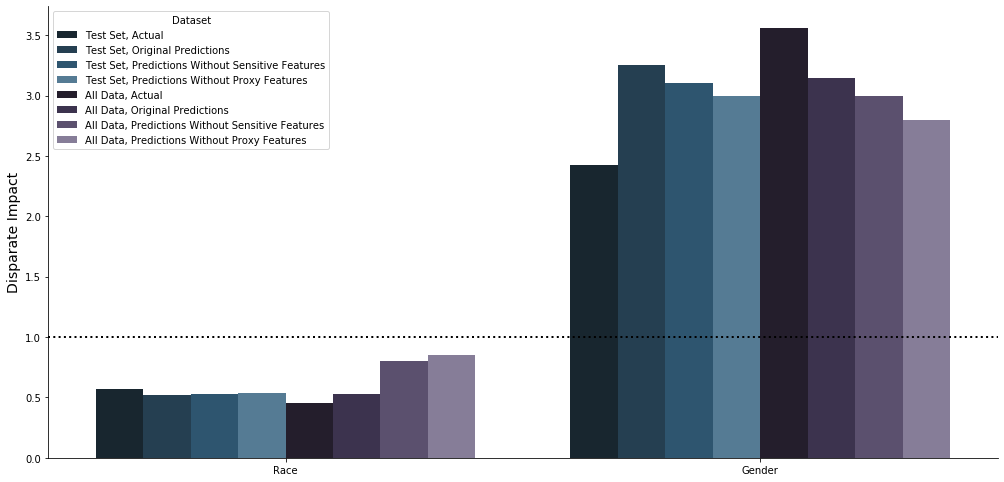

In [32]:
# plot DI

# Create an array with the colors for plot
colors = ['#142733', '#1d4159', '#23577a', '#4a7d9e', '#231c2e', '#3b2f52', '#594b73', '#85799c']

di_plot = sns.catplot(data=di_melt, 
                          x='variable', y='value', hue='Dataset', palette=sns.color_palette(colors),
                          kind='bar', aspect=2, height=7, legend_out=False)

di_plot.axes[0][0].set_xlabel('')
di_plot.axes[0][0].set_ylabel('Disparate Impact', fontsize=14)
plt.axhline(1, color='black', linestyle='dotted', linewidth=2)
plt.show()

In [174]:
def get_stats(X_sub, col):
    
    # get target variable subset
    ind = X_sub.index
    y_sub = y_test[ind]
    
    # for subset, get predictions and probabilities for positive class 
    pred_sub = clf_total.predict(X_sub)
    pred_proba_sub = clf_total.predict_proba(X_sub)
    
    # get FPR, TPR
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_sub, pred_proba_sub[:,1])
    
    # get confusion matrix
    confmat_sub = sklearn.metrics.confusion_matrix(y_sub, pred_sub, labels=[1,0])
    tp = confmat_sub[0,0] # number of true positives
    fp = confmat_sub[1,0] # number of false positives
    fn = confmat_sub[0,1] # number of false negatives
    tn = confmat_sub[1,1] # number of true negatives
    
    # create dataframe with stats
    stats = pd.DataFrame(data={col:[len(pred_sub), # group size
                                    round(sum(pred_sub)/len(pred_sub), 4), #pred prev
                                    round((tp+tn)/len(pred_sub), 4), # accuracy
                                    round(fn/(fn+tp), 4), # fnr
                                    round(fp/(fp+tn), 4), # fpr
                                    round(tp/(tp+fn), 4), # recall
                                    round(sklearn.metrics.auc(fpr, tpr), 4) # auc 
                                   ]}, 
                 index=['Test Set Group Size (N)', 'Predicted Prevalence', 
                        'Accuracy', 'FNR', 'FPR', 'Recall', 'AUC'])
    # transpose df
    stats = stats.T
    stats['Test Set Group Size (N)'] = stats['Test Set Group Size (N)'].astype(int)
    
    # display dataframe with stats
    display(stats)
    
    #plot confusion matrix
    sklearn.metrics.plot_confusion_matrix(clf_total, X_sub, y_sub, labels=[1,0])
    plt.show()
    
    print('\n')
    
    # return dataframe with stats
    return stats
    
    
def subgroup_stats(category1, category2=None):
    '''
    Takes in 1 or 2 pre-OHE column names (e.g., 'race' and 'gender').
    If 2 categories given, produces intersectional statistics.
    
    Note: Does not support intersectional analysis with age
    '''
    # get list of OHE columns for category 1
    if category1 != 'age_at_incident':
        cols_1 = [x for x in X_test.columns if x.startswith(category1+'_')]
        
    # get overall stats
    total_stats = get_stats(X_test, 'Overall')
    
    # intersectional analysis
    if category2 !=None:
        assert category1!='age_at_incident' and category2!='age_at_incident', \
                                         'Intersectional analysis not supported for age'
        
        # get list of OHE columns for category 1
        cols_2 = [x for x in X_test.columns if x.startswith(category2+'_')]
        
        for x in cols_1:
            # for each value of category 1, create subset
            X_sub = X_test[X_test[x]==1]
            
            # continue if subset is empty
            if len(X_sub)==0:
                print(x,'\n\t No members of this subgroup present in the test set. \n')
                continue
                
            # if category 1 subset not empty, create sub-subsets
            else:
            
                for y in cols_2:
                    # create sub-subset for each value of category 2
                    X_sub = X_test[X_test[x]==1]
                    X_sub = X_sub[X_sub[y]==1]
                    if len(X_sub)==0:
                        print(x+' and '+y,
                              '\n\t No members of this subgroup present in the test set. \n')
                    else:
                        # get stats if sub-subset not empty
                        sub_stats = get_stats(X_sub, x+' and '+y)
                        total_stats = pd.concat([total_stats, sub_stats])
                        
    # single trait only
    else:
        if category1 != 'age_at_incident':
            for x in cols_1:
                # for each value of category 1, create subset
                X_sub = X_test[X_test[x]==1]
                if len(X_sub)==0:
                    print(x,'\n\t No members of this subgroup present in the test set. \n')
                else:
                    # get stats if subset not empty
                    sub_stats = get_stats(X_sub, x)
                    total_stats = pd.concat([total_stats, sub_stats])
            
        # special method for age
        else:
            # cut age into bins
            cut = pd.cut(X_test['age_at_incident'], 
                         bins=[X_test['age_at_incident'].min(), 
                               20, 23, 27, 30, 35, 40, 50, 60, 70, 
                               X_test['age_at_incident'].max()+1], 
                         labels=False, right=False, retbins=True)
            
            # save age_at_incident encoded by bin numbers
            age_binned = cut[0]
            
            # save bins
            bins = cut[1]
            
            for x in sorted(age_binned.unique()):
                # create subset for each bin
                this_bin = age_binned[age_binned==x].index
                X_sub = X_test.loc[this_bin]
                
                # create bin labels
                edges = '{}-{}'.format(int(bins[int(x)]), int(bins[int(x)+1]-1))
                if bins[int(x)] == bins[int(x)+1]-1:
                    # if bin contains only 1 age, change label to single number
                    edges = str(int(bins[int(x)]))
            
                if len(X_sub)==0:
                    if not np.isnan(x):
                        print(x,
                              '\n\t No members of this subgroup present in the test set. \n')
                else:
                    # get stats if subset not empty
                    sub_stats = get_stats(X_sub, edges)
                    total_stats = pd.concat([total_stats, sub_stats])
                    
    display(total_stats)
    print('\n')
    
    return total_stats

In [326]:
def plain_group(x):
    
    split = x.split('_', 1)
    if len(split)==1:
        return split[0].title()
    if len(split)==2:
        return split[1].title()
    return

def plot_stats(stat_df_full, age=False):
    
    stat_df = stat_df_full.iloc[1:]
    
    if not age:
        # Set category (e.g. "Gender")
        cat = stat_df.index[-1].split('_', 1)[0].title()

        # Create column with category values and test set size
        stat_df[cat] = stat_df.index.map(plain_group) + ', N=' + \
                            stat_df['Test Set Group Size (N)'].astype(str)

        stat_df = stat_df.sort_values(by=['Predicted Prevalence'])
        
        # Set palette
        palette='muted'
    
    if age:
        # Set category to "Age"
        cat = 'Age'
        
        # Create column with category values and test set size
        stat_df[cat] = stat_df.index + ', N=' + \
                            stat_df['Test Set Group Size (N)'].astype(str)
        
        # Set sequential palette
        palette = 'GnBu'

    # melt df to prepare for sns.catplot
    df_melt = stat_df.melt(id_vars=[cat], 
                  value_vars=['Predicted Prevalence', 'Accuracy', 
                              'FNR', 'FPR', 'Recall', 'AUC'])

    # plot metrics
    stat_plot = sns.catplot(data=df_melt, 
                              x='variable', y='value', hue=cat,
                              kind='bar', palette=palette,
                            aspect=2, height=6, legend_out=False)
    
    stat_plot.axes[0][0].set_xlabel('')
    stat_plot.axes[0][0].set_ylabel('')
    
    return

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
Overall,43363,0.2384,0.7651,0.2077,0.235,0.7923,0.8411


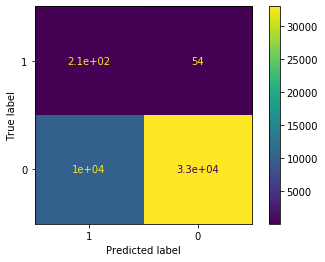

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
17-19,2623,0.1956,0.8048,0.4,0.1948,0.6,0.8105


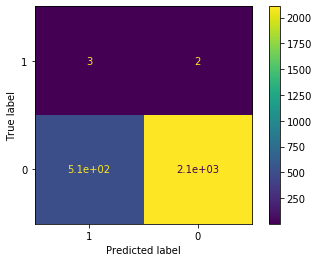

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
20-22,5022,0.181,0.8216,0.3415,0.1771,0.6585,0.8178


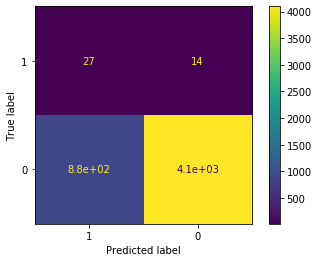

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
23-26,6977,0.1807,0.8217,0.2703,0.1778,0.7297,0.8136


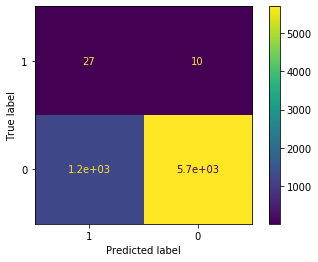

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
27-29,5111,0.2475,0.7554,0.2414,0.2446,0.7586,0.8355


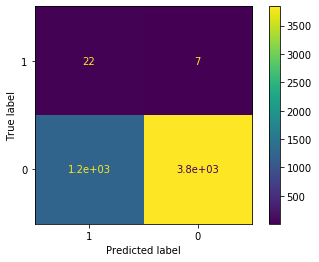

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
30-34,5800,0.24,0.7657,0.0976,0.2353,0.9024,0.8843


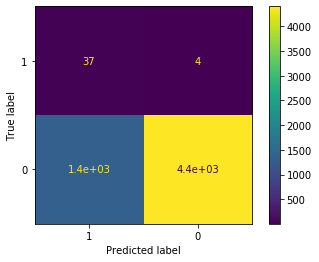

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
35-39,4314,0.2508,0.752,0.2,0.2483,0.8,0.8239


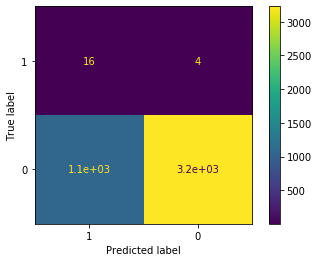

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
40-49,6390,0.2962,0.7089,0.1333,0.2922,0.8667,0.8841


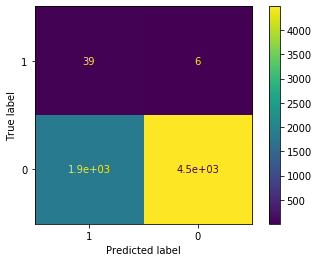

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
50-59,5296,0.3014,0.703,0.1714,0.2979,0.8286,0.829


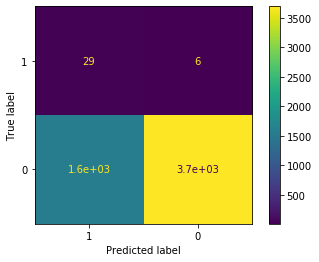

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
60-69,1663,0.2249,0.7787,0.0,0.2221,1.0,0.9133


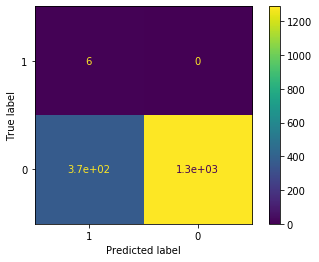

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
70-82,167,0.3114,0.6826,1.0,0.3133,0.0,0.1867


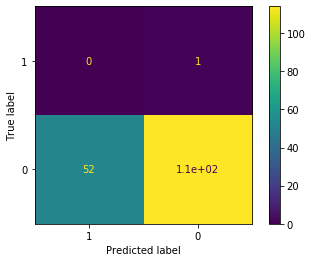

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
Overall,43363,0.2384,0.7651,0.2077,0.2350,0.7923,0.8411
17-19,2623,0.1956,0.8048,0.4000,0.1948,0.6000,0.8105
20-22,5022,0.1810,0.8216,0.3415,0.1771,0.6585,0.8178
23-26,6977,0.1807,0.8217,0.2703,0.1778,0.7297,0.8136
27-29,5111,0.2475,0.7554,0.2414,0.2446,0.7586,0.8355
30-34,5800,0.2400,0.7657,0.0976,0.2353,0.9024,0.8843
35-39,4314,0.2508,0.7520,0.2000,0.2483,0.8000,0.8239
40-49,6390,0.2962,0.7089,0.1333,0.2922,0.8667,0.8841
50-59,5296,0.3014,0.7030,0.1714,0.2979,0.8286,0.8290
60-69,1663,0.2249,0.7787,0.0000,0.2221,1.0000,0.9133


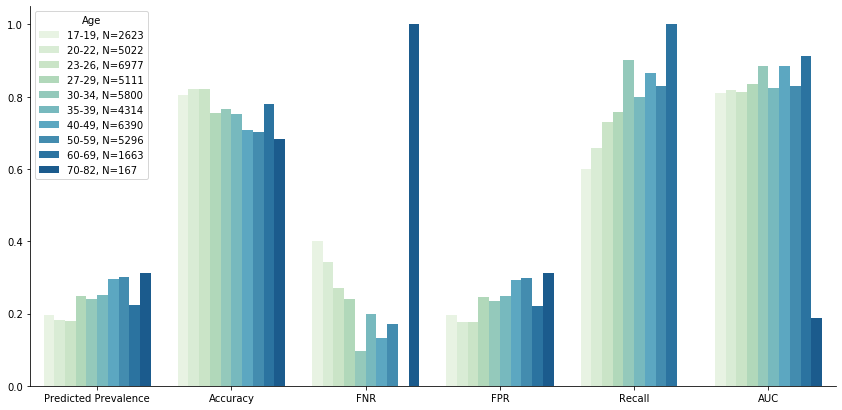

In [330]:
age_stats = subgroup_stats('age_at_incident')
plot_stats(age_stats, age=True)

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
Overall,43363,0.2384,0.7651,0.2077,0.235,0.7923,0.8411


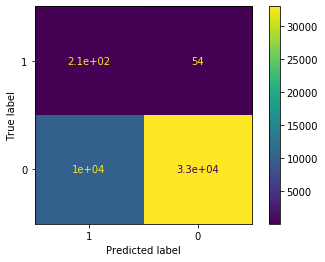

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
gender_female,5582,0.6141,0.3968,0.0704,0.6101,0.9296,0.8228


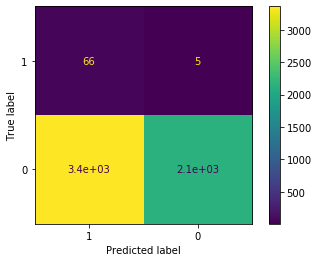

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
gender_male,37546,0.1831,0.8194,0.2593,0.1802,0.7407,0.8395


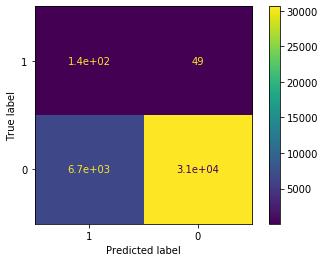

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
gender_unknown,235,0.1532,0.8468,NaN,0.1532,NaN,NaN


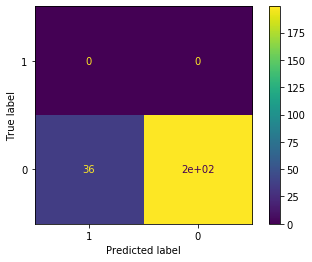

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
Overall,43363,0.2384,0.7651,0.2077,0.2350,0.7923,0.8411
gender_female,5582,0.6141,0.3968,0.0704,0.6101,0.9296,0.8228
gender_male,37546,0.1831,0.8194,0.2593,0.1802,0.7407,0.8395
gender_unknown,235,0.1532,0.8468,NaN,0.1532,NaN,NaN


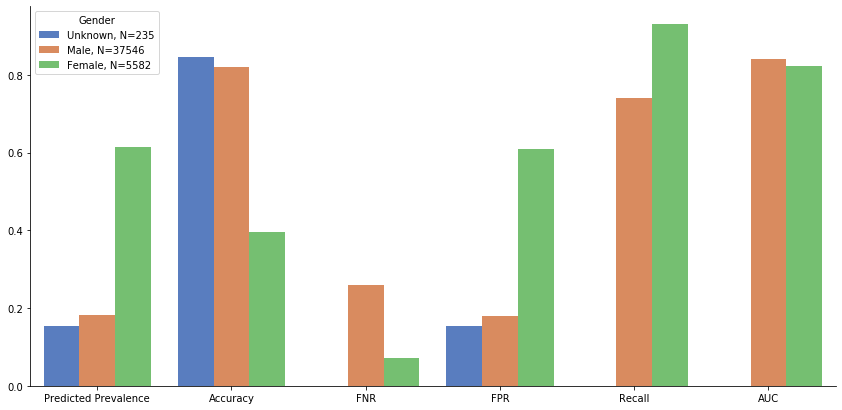

In [331]:
gender_stats = subgroup_stats('gender')
plot_stats(gender_stats)

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
Overall,43363,0.2384,0.7651,0.2077,0.235,0.7923,0.8411


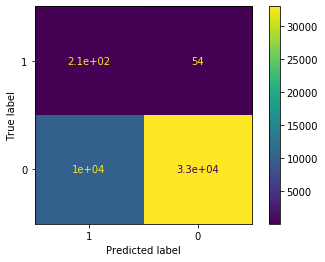



race_albino 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_american indian,7,0.7143,0.2857,NaN,0.7143,NaN,NaN


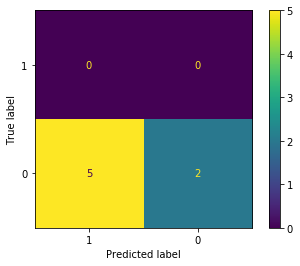

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_asian,224,0.3214,0.692,0.0,0.3122,1.0,0.8612


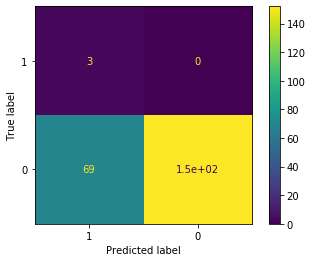

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_biracial,5,0.2,0.8,NaN,0.2,NaN,NaN


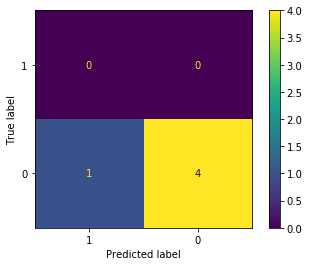

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_black,29269,0.2143,0.7889,0.2262,0.2111,0.7738,0.8407


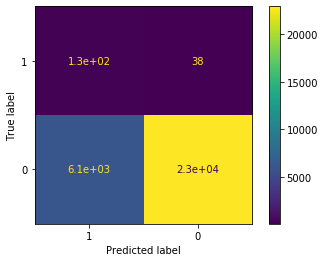

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_hispanic,446,0.1076,0.8946,0.0,0.1056,1.0,0.9933


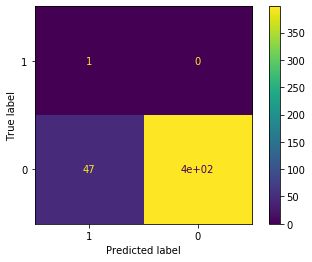

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_unknown,420,0.181,0.819,NaN,0.181,NaN,NaN


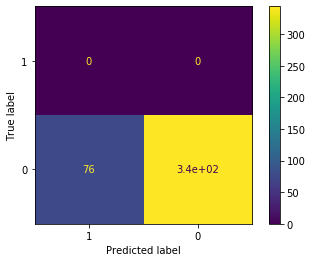

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white,6000,0.407,0.6005,0.1053,0.4023,0.8947,0.8423


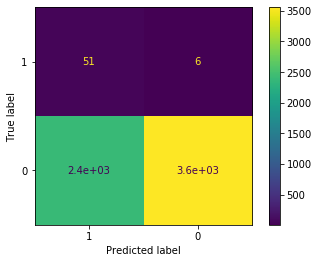

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white [hispanic or latino],6751,0.2023,0.799,0.3448,0.2004,0.6552,0.7919


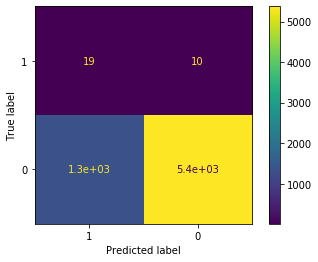

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white/black [hispanic or latino],241,0.2282,0.7801,0.0,0.2218,1.0,1.0


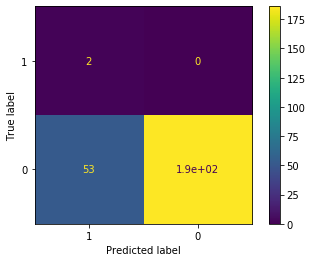

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
Overall,43363,0.2384,0.7651,0.2077,0.2350,0.7923,0.8411
race_american indian,7,0.7143,0.2857,NaN,0.7143,NaN,NaN
race_asian,224,0.3214,0.6920,0.0000,0.3122,1.0000,0.8612
race_biracial,5,0.2000,0.8000,NaN,0.2000,NaN,NaN
race_black,29269,0.2143,0.7889,0.2262,0.2111,0.7738,0.8407
race_hispanic,446,0.1076,0.8946,0.0000,0.1056,1.0000,0.9933
race_unknown,420,0.1810,0.8190,NaN,0.1810,NaN,NaN
race_white,6000,0.4070,0.6005,0.1053,0.4023,0.8947,0.8423
race_white [hispanic or latino],6751,0.2023,0.7990,0.3448,0.2004,0.6552,0.7919
race_white/black [hispanic or latino],241,0.2282,0.7801,0.0000,0.2218,1.0000,1.0000


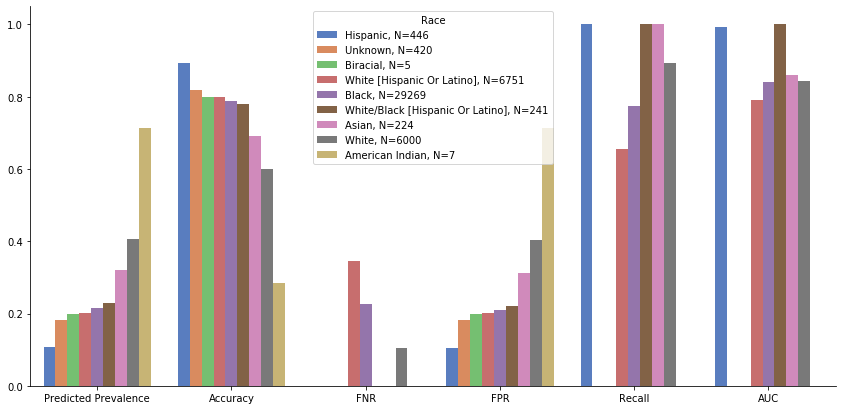

In [332]:
race_stats = subgroup_stats('race')
plot_stats(race_stats)

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
Overall,43363,0.2384,0.7651,0.2077,0.235,0.7923,0.8411


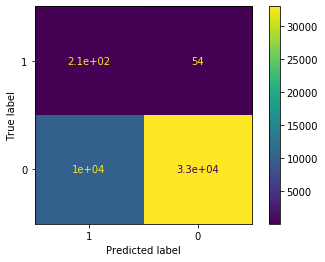



race_albino 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_american indian and gender_female,3,1.0,0.0,NaN,1.0,NaN,NaN


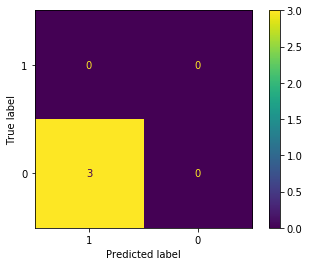

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_american indian and gender_male,4,0.5,0.5,NaN,0.5,NaN,NaN


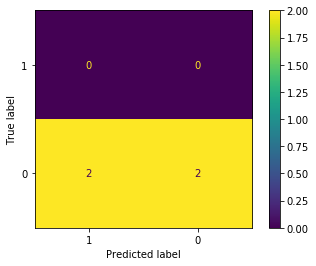



race_american indian and gender_unknown 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_asian and gender_female,39,0.6923,0.3333,0.0,0.6842,1.0,0.9474


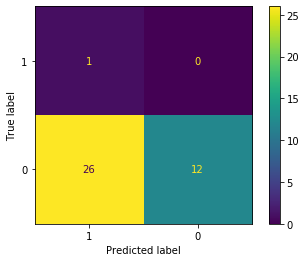

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_asian and gender_male,185,0.2432,0.7676,0.0,0.235,1.0,0.8634


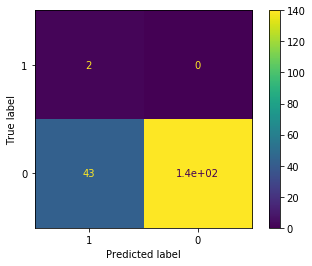



race_asian and gender_unknown 
	 No members of this subgroup present in the test set. 

race_biracial and gender_female 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_biracial and gender_male,5,0.2,0.8,NaN,0.2,NaN,NaN


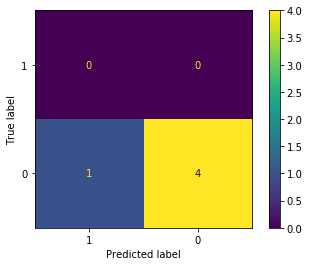



race_biracial and gender_unknown 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_black and gender_female,3424,0.6133,0.3992,0.0426,0.6085,0.9574,0.8187


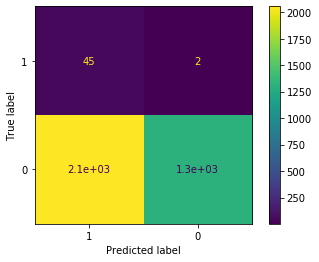

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_black and gender_male,25824,0.1616,0.8403,0.2975,0.159,0.7025,0.8359


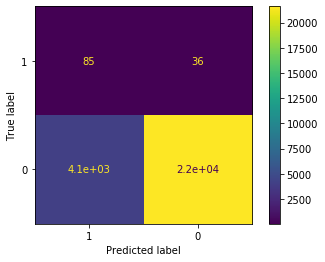

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_black and gender_unknown,21,0.0,1.0,NaN,0.0,NaN,NaN


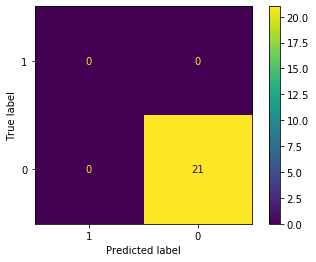

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_hispanic and gender_female,45,0.4889,0.5333,0.0,0.4773,1.0,0.9318


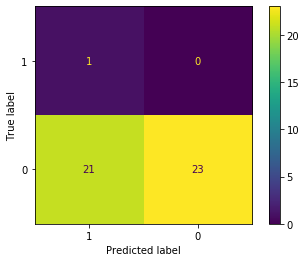

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_hispanic and gender_male,401,0.0648,0.9352,NaN,0.0648,NaN,NaN


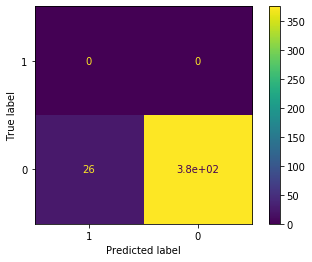



race_hispanic and gender_unknown 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_unknown and gender_female,34,0.5294,0.4706,NaN,0.5294,NaN,NaN


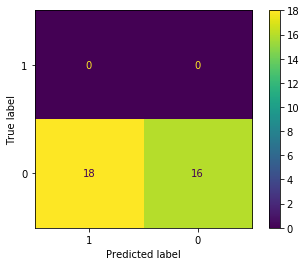

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_unknown and gender_male,178,0.1236,0.8764,NaN,0.1236,NaN,NaN


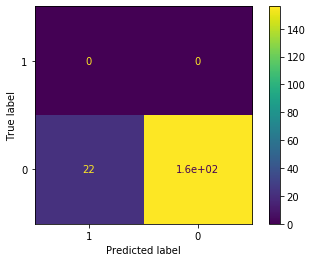

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_unknown and gender_unknown,208,0.1731,0.8269,NaN,0.1731,NaN,NaN


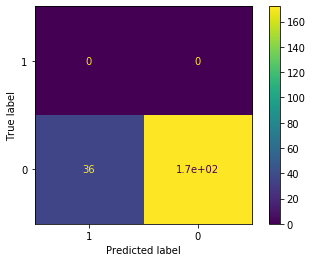

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white and gender_female,1345,0.6431,0.3651,0.0769,0.6404,0.9231,0.8544


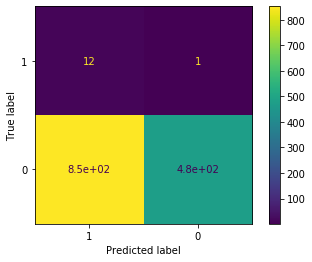

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white and gender_male,4653,0.3389,0.6684,0.1136,0.3337,0.8864,0.855


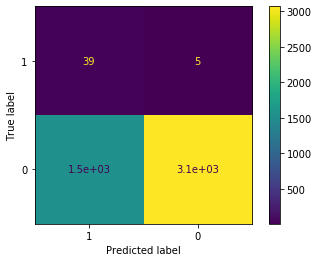

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white and gender_unknown,2,0.0,1.0,NaN,0.0,NaN,NaN


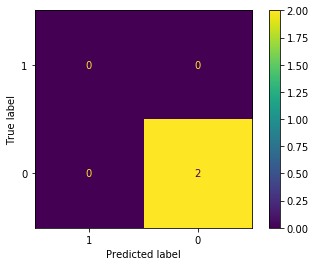

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white [hispanic or latino] and gender_female,664,0.5633,0.4413,0.2857,0.5616,0.7143,0.7364


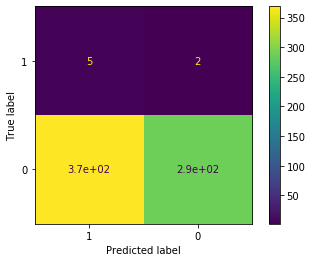

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white [hispanic or latino] and gender_male,6083,0.1631,0.8379,0.3636,0.1614,0.6364,0.7814


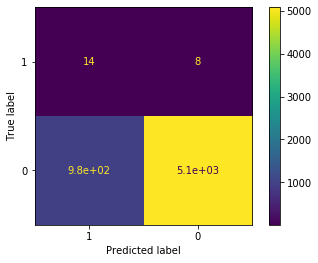

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white [hispanic or latino] and gender_unknown,4,0.0,1.0,NaN,0.0,NaN,NaN


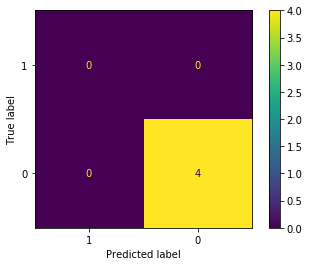

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white/black [hispanic or latino] and gender_female,28,0.6786,0.3929,0.0,0.6538,1.0,1.0


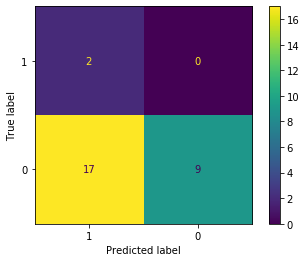

,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
race_white/black [hispanic or latino] and gender_male,213,0.169,0.831,NaN,0.169,NaN,NaN


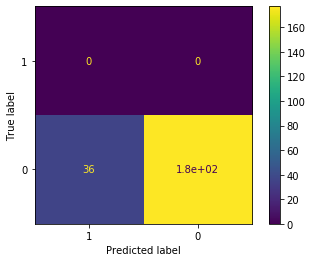



race_white/black [hispanic or latino] and gender_unknown 
	 No members of this subgroup present in the test set. 



,Test Set Group Size (N),Predicted Prevalence,Accuracy,FNR,FPR,Recall,AUC
Overall,43363,0.2384,0.7651,0.2077,0.2350,0.7923,0.8411
race_american indian and gender_female,3,1.0000,0.0000,NaN,1.0000,NaN,NaN
race_american indian and gender_male,4,0.5000,0.5000,NaN,0.5000,NaN,NaN
race_asian and gender_female,39,0.6923,0.3333,0.0000,0.6842,1.0000,0.9474
race_asian and gender_male,185,0.2432,0.7676,0.0000,0.2350,1.0000,0.8634
race_biracial and gender_male,5,0.2000,0.8000,NaN,0.2000,NaN,NaN
race_black and gender_female,3424,0.6133,0.3992,0.0426,0.6085,0.9574,0.8187
race_black and gender_male,25824,0.1616,0.8403,0.2975,0.1590,0.7025,0.8359
race_black and gender_unknown,21,0.0000,1.0000,NaN,0.0000,NaN,NaN
race_hispanic and gender_female,45,0.4889,0.5333,0.0000,0.4773,1.0000,0.9318


In [8]:
race_and_gender_stats = subgroup_stats('race', 'gender')